In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation
from scipy import ndimage

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
%load_ext autoreload
%autoreload 2

# Synthetic growth covid lesions

> We use texture synthesis and celluar automata to synthesize covid lesions growth.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

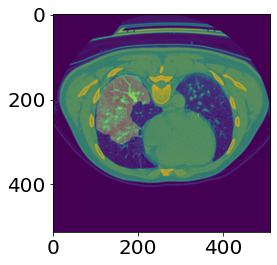

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'

ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
plt.imshow(ct[...,100])
plt.imshow(ct_mask[...,100], alpha=.3);

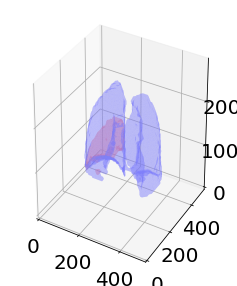

In [ ]:
#@title plot ct {vertical-output: true}
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
a=np.moveaxis(largest_component,2,0)
b=np.moveaxis(ct_mask_small,2,0)
plot_3d_2(a, b, .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

118
2


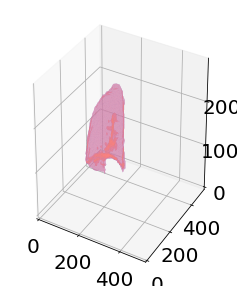

In [ ]:
#@title erode masks to separate the two lungs and get indiviual masks {vertical-output: true}
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
print(nr)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
print(nr)
plot_3d_2(np.moveaxis(two_lungs==2,2,0), np.moveaxis(two_lungs==2,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

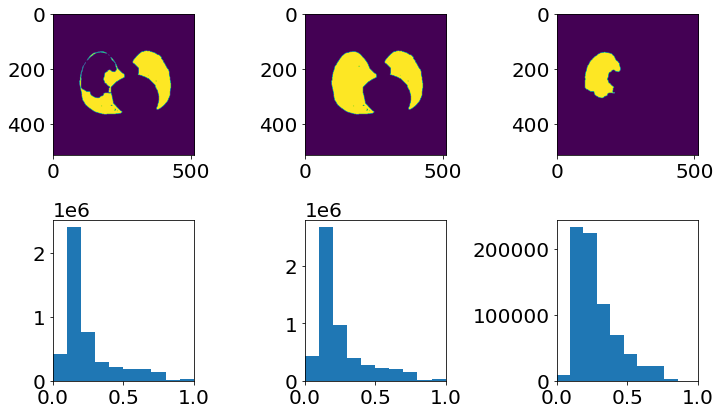

In [ ]:
#@title get masks {vertical-output: true}
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask
target_mask2 = ~bkgd
target_mask3 = ct_mask_small.astype(bool)
# ========
SLICE=100
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax[0,0].imshow(target_mask[...,SLICE])
ax[1,0].hist(ct_small[np.where(target_mask!=0)].flatten()); ax[1,0].set_xlim([0,1]);
ax[0,1].imshow(target_mask2[...,SLICE])
ax[1,1].hist(ct_small[np.where(target_mask2!=0)].flatten()); ax[1,1].set_xlim([0,1]);
ax[0,2].imshow(target_mask3[...,SLICE])
ax[1,2].hist(ct_small[np.where(target_mask3!=0)].flatten()); ax[1,2].set_xlim([0,1]);
plt.tight_layout()

26 141 364 97 241 64 165


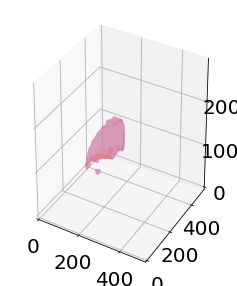

In [ ]:
#@title label {vertical-output: true}
lab, nr_ = label(target_mask3)
y_max, y_min, x_max, x_min, z_max, z_min = get_min_max(target_mask3)
print(nr_, y_max, y_min, x_max, x_min, z_max, z_min)
plot_3d_2(np.moveaxis(target_mask3,2,0), np.moveaxis(target_mask3,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

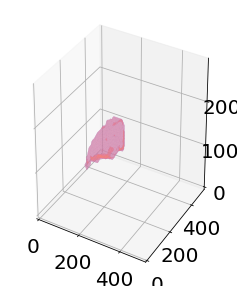

1 339 141 241 97 165 64


In [ ]:
#@title get only one big lesion {vertical-output: true}

lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
plot_3d_2(np.moveaxis(one_big_lesion,2,0), np.moveaxis(one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
print(nr_,y_max_lesion, y_min_lesion, x_max_lesion, x_min_lesion, z_max_lesion, z_min_lesion)

141 339 97 241 64 165 2
140 362 97 265 41 245


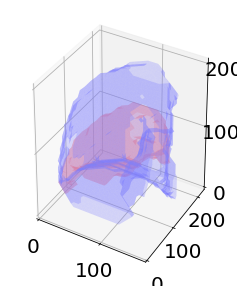

In [ ]:
#@title get lung that contains lesion {vertical-output: true}
for i in np.arange(1,3):
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    print(y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion, i)
    print(y_min, y_max, x_min, x_max, z_min, z_max)
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
plot_3d_2(np.moveaxis(lung_inpaint>0,2,0), np.moveaxis(lung_one_big_lesion,2,0), .5, detail_speed=8, detail_speed2=8, figsize=(4,5))

[False  True]
(224, 192, 224) (224, 192, 224) (224, 192, 224)


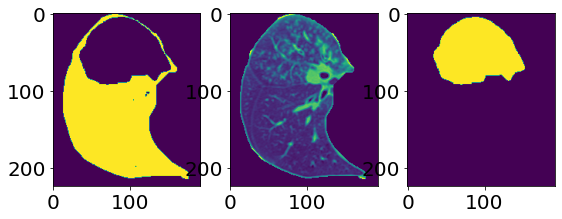

In [ ]:
#@title add zeros outsides the lungs to the mask until multiple of 32 {vertical-output: true}
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
print(np.unique(mask_inpain))
print(np.shape(mask_inpain), np.shape(img), np.shape(lung_one_lesion))
fig, ax = plt.subplots(1,3, figsize=(9,6))
ax[0].imshow(mask_inpain[...,100])
ax[1].imshow(img[...,100])
ax[2].imshow(lung_one_lesion[...,100])

(224, 192, 224)
(198, 144, 101)


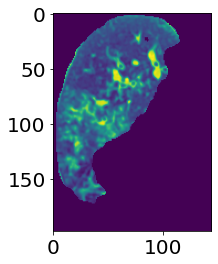

In [ ]:
#@title focus on the lesion {vertical-output: true}
target_img_covid = img * lung_one_lesion
print(np.shape(target_img_covid))
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
print(np.shape(target_img_covid))
plt.imshow(target_img_covid[...,30])

(198, 144, 4)


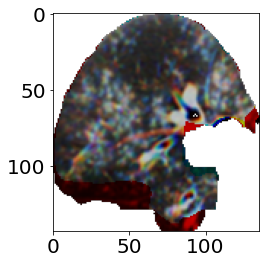

In [ ]:
#@title if RGB-like image was needed {vertical-output: true}
TARGET_SLICE = 50
target_img = target_img_covid[...,TARGET_SLICE:TARGET_SLICE+4] 
print(np.shape(target_img))
target_img[...,-1] = np.sum(target_img, axis=-1) > 0
## crop to only lesion
y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(target_img[...,-1:])
target_img = target_img[y_min: y_max, x_min: x_max, ...].astype('float32')
plt.imshow(target_img);

## Clustering

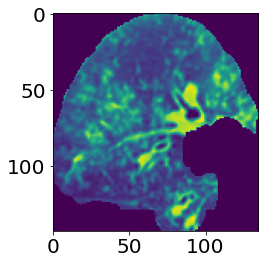

In [ ]:
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(np.expand_dims(im,-1)>0)
im2 = im[y_min: y_max, x_min: x_max]
plt.imshow(im2)

In [ ]:
SLICE = 50
im = copy(target_img_covid[...,SLICE])

(-0.5, 143.5, 197.5, -0.5)

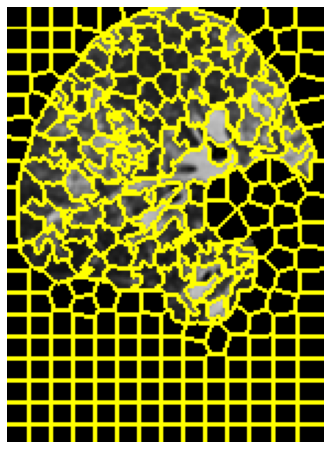

In [ ]:
numSegments = 300
segments = slic(im, n_segments = numSegments, sigma = .2, multichannel=False, compactness=.1)
# show the output of SLIC
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(im, segments))
plt.axis("off")

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


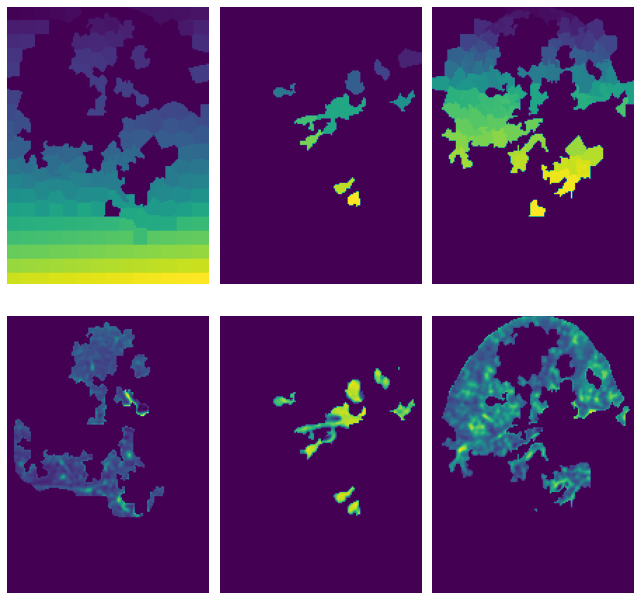

In [ ]:
#@title clustering with superpixels {vertical-output: true}
background, lesion_area, vessels = superpixels(im, segments, vessel_threshold=.5)
fig, ax = plt.subplots(2,3, figsize=(9,9))
ax[0,0].imshow(background)
ax[0,1].imshow(vessels)
ax[0,2].imshow(lesion_area)
ax[1,0].imshow((background>0)*im)
ax[1,1].imshow((vessels>0)*im)
ax[1,2].imshow((lesion_area>0)*im)
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
def shuffle_order_of_clusters_for_plot(lesion_area_merged):
  '''just shuffle the cluster names so they don't look merged when they are not'''
  len_unique = len(np.unique(lesion_area_merged1)-1)
  seq_shufled = np.linspace(1,len_unique,len_unique)
  np.random.shuffle(seq_shufled)
  lesion_area_plot = np.zeros_like(lesion_area_merged)
  for idx, i in enumerate(np.unique(lesion_area_merged)[1:]):
    lesion_area_plot[lesion_area_merged==i] = seq_shufled[idx]
  return lesion_area_plot

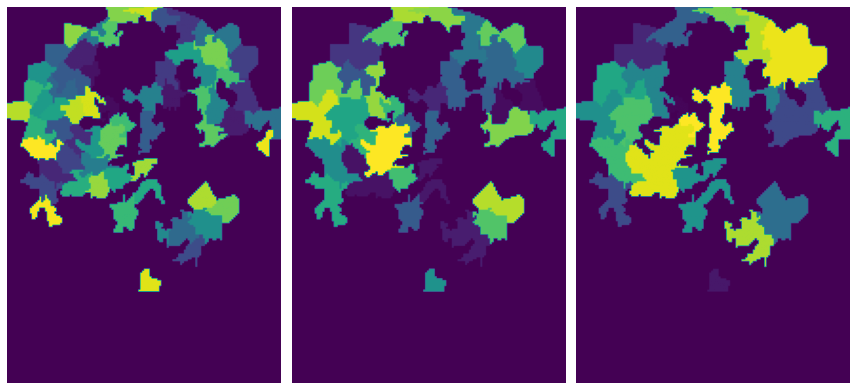

In [ ]:
##@title merged close clusters {vertical-output: true}
lesion_area_merged1 = merge_labeled_clusters(lesion_area, DIST=20)
lesion_area_merged2 = merge_labeled_clusters(lesion_area_merged1, DIST=30)
lesion_area_merged = merge_labeled_clusters(lesion_area_merged2, DIST=40)
fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(shuffle_order_of_clusters_for_plot(lesion_area_merged1), cmap='viridis')
ax[1].imshow(shuffle_order_of_clusters_for_plot(lesion_area_merged2), cmap='viridis')
ax[2].imshow(shuffle_order_of_clusters_for_plot(lesion_area_merged), cmap='viridis')
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

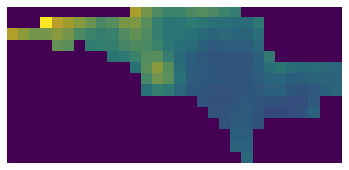

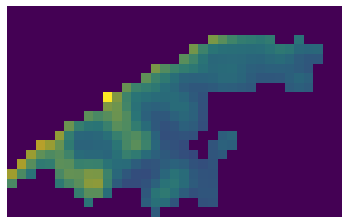

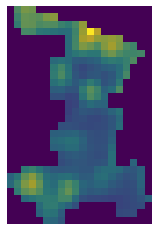

In [ ]:
#@title select_lesions_match_conditions and make seeds {vertical-output: true}
tgt_minis, tgt_minis_coords, tgt_minis_masks, tgt_minis_big, tgt_minis_coords_big, tgt_minis_masks_big = select_lesions_match_conditions(lesion_area_merged, target_img_covid, skip_index=0)
targets, coords, masks, seeds = make_list_of_targets_and_seeds(tgt_minis, tgt_minis_coords, tgt_minis_masks, seed_method='max')
for idx, (i,j) in enumerate(zip(targets,seeds)):
  if idx == 3: break
  plt.figure()
  plt.imshow(i[...,0])
  plt.imshow(j, alpha=.3)
  plt.axis('off')

## cellular automata

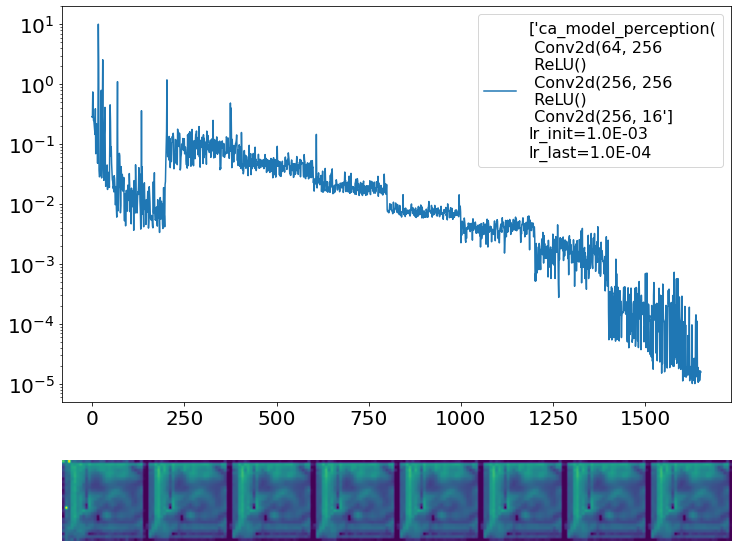

1650 1.5840916603337973e-05
4.8 mins
(256, 28, 29)
15


In [ ]:
# main cellular automata training loop
device = 'cuda'
num_channels = 16
epochs = 2500
sample_size = 8
GROW_ON_K_ITER = 1
BACKGROUND_INTENSITY = 0.19
STEP_SIZE = 1 #.3
SCALE_MASK = 1 #0.19
path_parent = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient06'
path_save_synthesis = f'{path_parent}_grow={GROW_ON_K_ITER}_bg={BACKGROUND_INTENSITY:.02f}_step={STEP_SIZE}_scale_mask={SCALE_MASK}/'
Path(path_save_synthesis).mkdir(parents=True, exist_ok=True)

for idx_lesion, (target, coord, mask, this_seed) in enumerate(zip(targets, coords, masks, seeds)):
  # if idx_lesion>6:continue
  # prepare seed
  height, width, _ = np.shape(target)
  seed = np.zeros([1, height, width, num_channels], np.float32)
  for i in range(num_channels-1):
    seed[:,..., i+1] = this_seed
  # initialize model
  model = ca_model_step_size(device = device, grow_on_k_iter=GROW_ON_K_ITER, background_intensity=BACKGROUND_INTENSITY, step_size=STEP_SIZE, scale_mask=SCALE_MASK)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500,2500], gamma=0.1) ## keep 1e-4 longer
  model_str = correct_label_in_plot(model)
  # Preparing the seed pool
  target0 = target
  pool_size = 1024
  seed_tensor = torch.tensor(seed).permute(0,-1,1,2).to(device)
  target = torch.tensor(target0.transpose(-1,0,1)).unsqueeze(0).to(device)
  seed_pool = torch.repeat_interleave(seed_tensor, repeats = pool_size, dim = 0)
  losses = []
  # train automata
  target_batch = torch.repeat_interleave(target, repeats = sample_size, dim = 0) .to('cuda')
  start = time()
  alive_masks = []
  mask_diffs=[]
  inner_iter2 = 0
  for i in range(epochs):
    ##
    if i < 100:
      inner_iter = 100
    elif i % 200 == 0: 
      inner_iter2 = inner_iter2 + 10
      inner_iter = np.min([inner_iter2, 100])

    scheduler.step()
    batch_idx = np.random.choice(len(seed_pool), sample_size, replace = False)
    seed_batch = seed_pool[batch_idx].to(device)
    seed_batch[:1] = seed_tensor.to(device)
    
    loss, out, alive_mask, mask_diff = model.train_step(
        target = target_batch, 
        target_loss_func = F.mse_loss, 
        iters = inner_iter,
        seed = seed_batch,
        current_epoch = i,
        masked_loss = False
        )
    
    alive_masks.append(alive_mask)
    mask_diffs.append(mask_diff)

    seed_pool[batch_idx] = out.detach().to(device)
    loss.backward() # calculate gradients
    model.normalize_grads() # normalize them
    optimizer.step() # update weights and biases 
    optimizer.zero_grad() # prevent accumulation of gradients
    losses.append(loss.item())
    #early-stopping
    if loss.item() < 1e-5: break

    if i % 50==0 or i  == epochs-1:
      model_str_final = plot_loss_and_lesion_synthesis(losses, optimizer, model_str, i, loss, sample_size, out)

  stop = time()
  time_total = f'{(stop-start)/60:.1f} mins'
  print(time_total)
  model_str_final = model_str_final + f'\nep={i}, {time_total}' # for reconstruction figure
  
  #save model
  torch.save(model.model.state_dict(), f'{path_save_synthesis}weights_{idx_lesion}.pt')

  #lesion synthesis
  x = torch.tensor(seed).permute(0,-1,1,2).to(device)
  outs = []
  with torch.no_grad():
    for i,special_sequence in zip(range(256),[1,1,1,3]*64):
      # x = model(x,special_sequence,101)
      x, alive_mask_, mask_diff_ = model(x,i,101)
      # x = model(x,i,i)
      out = np.clip(to_rgb(x[0].permute(-2, -1,0).cpu().detach().numpy()), 0,1)
      outs.append(out)
  
  #save results    
  outs_masked = []
  for out_ in outs:
      out_masked = np.squeeze(out_) * target[0,1,...].detach().cpu().numpy()
      out_masked[out_masked==1]=0
      outs_masked.append(out_masked)
  outs_int = np.asarray(outs_masked)
  print(np.shape(outs_int))
  outs_int = np.clip(outs_int, 0 ,1)
  outs_int = (outs_int*255).astype('int16')
  print(idx_lesion)
  # path_save_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient05_superpix_sigma=.2_compact=.1/'
  
  np.savez_compressed(f'{path_save_synthesis}lesion_{idx_lesion}.npz', outs_int)
  np.save(f'{path_save_synthesis}coords_lesion_{idx_lesion}.npy', coord)
  np.savez_compressed(f'{path_save_synthesis}mask_lesion_{idx_lesion}.npz', mask)
  np.save(f'{path_save_synthesis}loss_lesion_{idx_lesion}.npy', losses)
  np.save(f'{path_save_synthesis}total_time_lesion_{idx_lesion}_{time_total}.npy', time_total)

## TODO
- increase the iterations of the inner loop progresively   
- Start with good training, then when it's properly trained switch to growig the mask ocasionally   
- put a mask on the loss to focus on the are grown (and maybe a little more using dilations?)      
- use distance transform to give a weighted mask   
- CLAMP THE NEW ALIVE PIXELS TO THE VALUES OF THE INPAINTED VERSION   

## previous